<a href="https://colab.research.google.com/github/yanezdavid/Predicting-Home-Prices/blob/main/Predicting_Home_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Investigative Question:** Can we predict the value of houses in Boston?

# Load Data

In [117]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

#import libraries
import pandas as pd
import numpy as np

#load & preview data
df = pd.read_csv('/content/drive/MyDrive/Data Science/Data/boston 3.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


# Explore & Clean Data

**Data dictionary** from [Kaggle](https://www.kaggle.com/c/2403-boston-housing-dataset/overview):
* CRIM: per capita crime rate by town
* ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS: proportion of non-retail business acres per town
* CHAS: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
* NOX: nitric oxides concentration (parts per 10 million)
* RM: average number of rooms per dwelling
* AGE: proportion of owner-occupied units built prior to 1940
* DIS: weighted distances to five Boston employment centres
* RAD: index of accessibility to radial highways
* TAX: full-value property-tax rate per $10,000

* PTRATIO: pupil-teacher ratio by town
* B: the proportion of black people by town
* LSTAT: % lower status of the population
* **MEDV: Median value of owner-occupied homes in $1000's [Target Feature]**




In [118]:
#check dimensions of data
df.shape

(506, 14)

In [119]:
#confirm that the data types are correct & numerical for machine learning
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [120]:
#check for missing values that will interrupt some machine learning algorithms
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [121]:
#confirm there are no unwarranted duplicates
df.duplicated().sum()

0

In [122]:
#check for wrong inputs & categories in the dummy features representing categorical data
df['CHAS'].value_counts()

0    471
1     35
Name: CHAS, dtype: int64

In [123]:
df['RAD'].value_counts()

24    132
5     115
4     110
3      38
6      26
8      24
2      24
1      20
7      17
Name: RAD, dtype: int64

In [124]:
#remove data that are over 4 standard devations outside of the median (extreme outliers)
from scipy import stats

z = np.abs(stats.zscore(df))

outlier_filter = (z < 4).all(axis=1)

df = df[outlier_filter]

In [125]:
#confirm that the number of outliers was not too large
df.shape

(499, 14)

# EDA: Exploratory Data Analysis

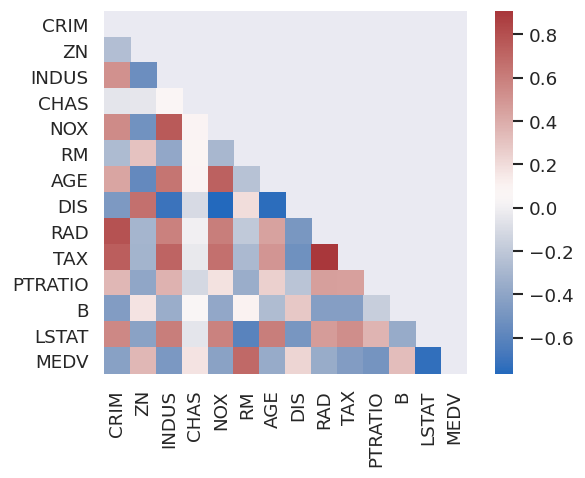

In [126]:
#visualie correlations between features
#check for multicollinearity in the data; if there are strong correlations between features...
#then we cannot reliably conduct linear regression as a form of machine learning
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,
            cmap='vlag',
            mask=mask,
            square=True);

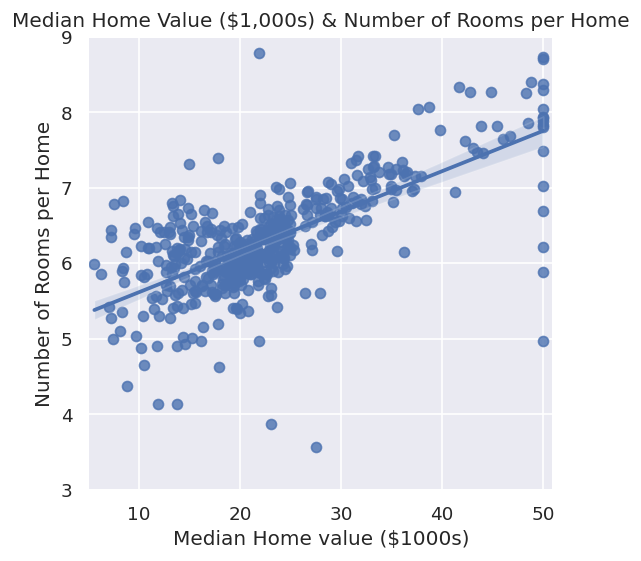

In [127]:
#relationships between features are strong; linear regression should be avoided
#visualize the relationship between home value and number of rooms
plt.figure(figsize=(5, 5));
sns.set(style="darkgrid");
sns.regplot(x=df['MEDV'],
            y=df['RM']);
plt.title('Median Home Value ($1,000s) & Number of Rooms per Home')
plt.xlim(5,51);
plt.xlabel('Median Home value ($1000s)');
plt.ylim(3,9);
plt.ylabel('Number of Rooms per Home');

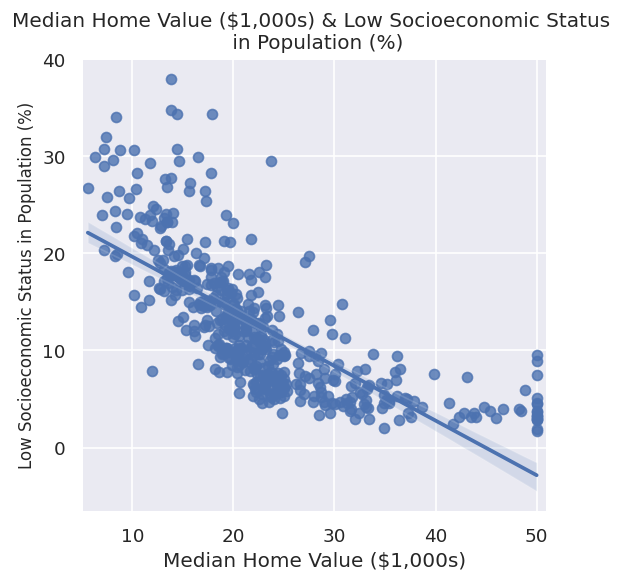

In [128]:
#visualize relationship between value and % of low SES in the population
plt.figure(figsize=(5, 5));
sns.regplot(x=df['MEDV'],
            y=df['LSTAT']);
plt.title('Median Home Value ($1,000s) & Low Socioeconomic Status \n in Population (%)')
plt.xlabel('Median Home Value ($1,000s)', fontsize=12);
plt.xlim(5,51)
plt.ylabel('Low Socioeconomic Status in Population (%)', fontsize=10);

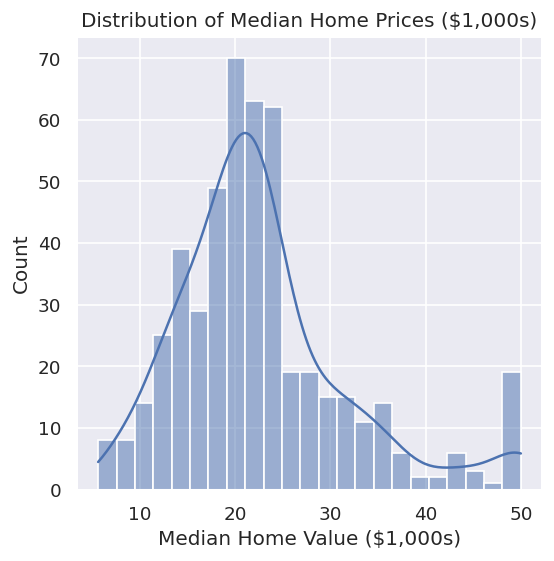

In [129]:
#visualize distribution of home prices to check for skewed/not normal data
plt.figure(figsize=(5, 5));
sns.histplot(x=df['MEDV'],
             kde=True);
plt.xlabel('Median Home Value ($1,000s)')
plt.title('Distribution of Median Home Prices ($1,000s)');

In [130]:
#describe differences between homes by rivers vs. homes without rivers
df.groupby(['CHAS']).mean()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CHAS,,,,,,,,,,,,,
0,2.923363,11.810345,10.912371,0.549972,6.2758,67.476509,3.886722,9.349138,406.006466,18.501940,357.341810,12.592931,22.298491
1,1.851670,7.714286,12.719143,0.593426,6.5196,77.500000,3.029709,9.314286,386.257143,17.491429,372.997429,11.241714,28.440000


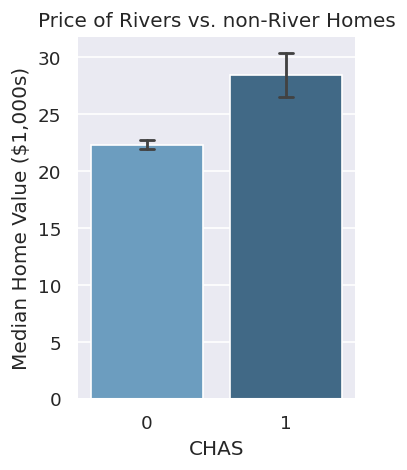

In [131]:
#visualize value of homes by rivers vs. homes without rivers
plt.figure(figsize=(3, 4));
sns.barplot(
    x='CHAS', 
    y='MEDV', 
    data=df, 
    ci=68, 
    color='#69b3a2',
    estimator=np.mean,
    capsize=.1,
    errwidth=1.7,
    palette="Blues_d",
    linewidth=1);
plt.title('Price of Rivers vs. non-River Homes');
plt.ylabel('Median Home Value ($1,000s)');

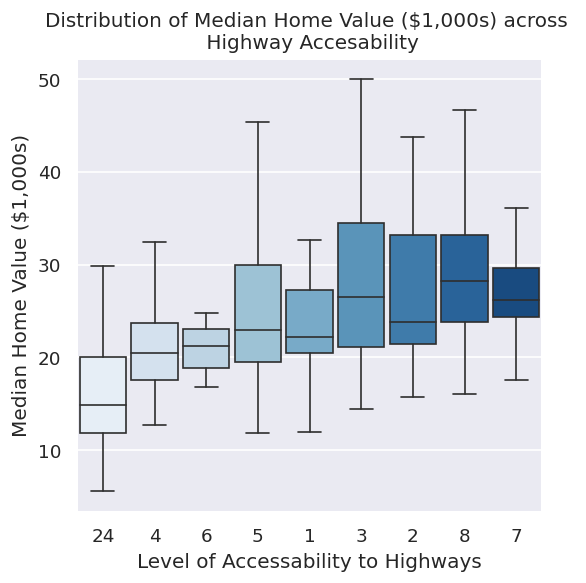

In [132]:
#visualize the distribution of home value by highway accessability rankings
plt.figure(figsize=(5, 5));
sns.boxplot(x='RAD',
            y='MEDV',
            data=df,
            palette='Blues',
            order=(24, 4, 6, 5, 1, 3, 2, 8, 7),
            linewidth=1,
            width=.9,
            showfliers=False);
plt.ylabel('Median Home Value ($1,000s)');
plt.xlabel('Level of Accessability to Highways');
plt.title('Distribution of Median Home Value ($1,000s) across \n Highway Accesability');

In [133]:
#use KMeans clustering to let unsupervised algorithms classify data into groups
#standardize data for KMeans performance
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit_transform(df)

kmeans = KMeans(n_clusters = 2)
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

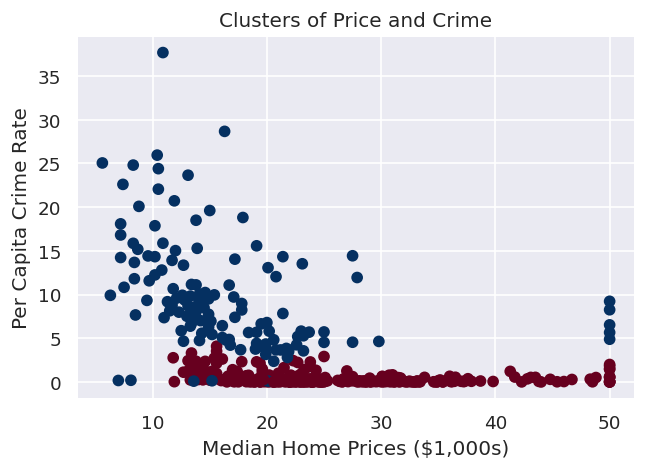

In [134]:
#visualize clusters between price and crime
df['cluster'] = kmeans.labels_
plt.scatter(df['MEDV'], df['CRIM'], c = df['cluster'], cmap='RdBu')
plt.xlabel('Median Home Prices ($1,000s)')
plt.ylabel('Per Capita Crime Rate')
plt.title('Clusters of Price and Crime');

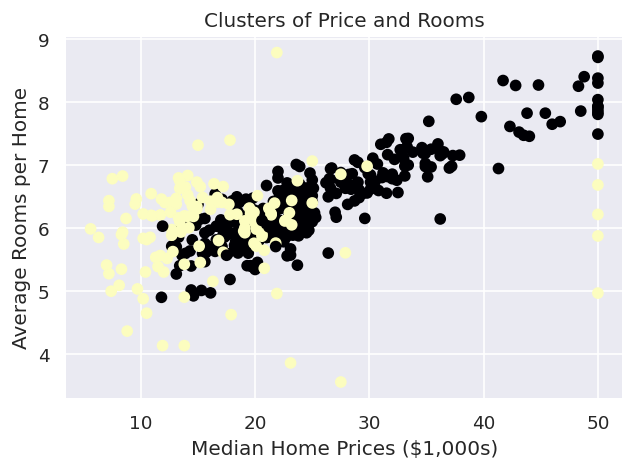

In [135]:
#visualize clusters between price and rooms
df['cluster'] = kmeans.labels_
plt.scatter(df['MEDV'], df['RM'], c = df['cluster'], cmap='magma')
plt.xlabel('Median Home Prices ($1,000s)')
plt.ylabel('Average Rooms per Home')
plt.title('Clusters of Price and Rooms');

# Random Forest Regressor

Split data into target vector and feature matrix.

In [136]:
from sklearn.model_selection import train_test_split, GridSearchCV

X = df.drop(columns=['MEDV'])
y = df['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=.3)

In [137]:
#create and fit default Random Forest
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [138]:
#score default Random Forest
from sklearn.metrics import mean_squared_error
from math import sqrt

rf_predicted_df = rf_regressor.predict(X_test)

print('RMSE: ' + str(sqrt(mean_squared_error(rf_predicted_opt, y_test))))
print('---------------------------------')
print('Testing Score: ' + str(rf_regressor.score(X_test, y_test)))

RMSE: 2.8810574987513013
---------------------------------
Testing Score: 0.8824212401636368


In [ ]:
#use GridSearchCV to find best hyperparameters for Random Forest
rf_estimator = RandomForestRegressor()

rf_params = {'n_estimators': range(50, 300, 50),
             'max_features': range(1, 30, 5),
             'max_depth': range(10, 200, 25),
             'min_samples_split': [2, 5, 10]}

rf_grid_search = GridSearchCV(
    estimator=rf_estimator,
    param_grid=rf_params, 
    cv = 5,
    n_jobs = -1,
    verbose = True,
    scoring='neg_mean_squared_error')

rf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.9s


In [ ]:
#recieve optimal hyperparameters for Random Forest
rf_grid_search.best_params_

In [ ]:
#tune and fit optimized Random Forest
rf_regressor_opt = RandomForestRegressor(max_depth = 60,
                                         n_estimators = 150,
                                         min_samples_split = 2,
                                         max_features = 11,
                                         bootstrap = True)

rf_regressor_opt.fit(X_train, y_train)

In [ ]:
#score optimized Random Forest
rf_predicted_opt = rf_regressor_opt.predict(X_test)

print('RMSE: ' + str(sqrt(mean_squared_error(rf_predicted_opt, y_test))))
print('---------------------------------')
print('Testing Score: ' + str(rf_regressor_opt.score(X_test, y_test)))

#default hyperparameters perform best after an exhastive GridSearchCV

# XGBoost Regression

Create and score baseline model.

In [ ]:
#create, fit, and score default XGBoost
from xgboost import XGBRegressor

XGB = XGBRegressor()
XGB.fit(X_train, y_train)
XGB_predicted_df = XGB.predict(X_test)

print('RMSE: ' + str(sqrt(mean_squared_error(XGB_predicted_df, y_test))))
print('---------------------------------')
print('Testing Score: ' + str(XGB.score(X_test, y_test)))

Run GridSearchCV to find optimal hyperparameters.

In [ ]:
#use GridSearchCV to find optimal hyperparameters
xgb_estimator = XGBRegressor()

xgb_params = {'learning_rate': [.001, .01, .1, .3, .5, .8],
          'max_depth': [1, 2, 3, 4, 5, 6],
          'max_features': [1, 2, 3, 4, 5, 6],
          'n_estimators': [20, 50, 80, 110, 140]}

xgb_grid_search = GridSearchCV(
    estimator=xgb_estimator,
    param_grid=xgb_params,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1,
    cv = 5,
    verbose=True)

xgb_grid_search.fit(X_train, y_train)

In [ ]:
#recieve optimal hyperparameters for XGBoost
xgb_grid_search.best_params_

Implement optimized model with best hyperparameters.

In [ ]:
#tune and fit optimized XGBoost
XGB_opt = XGBRegressor(learning_rate= 0.3,
                        max_depth = 6,
                        max_features = 1,
                        n_estimators = 50)

XGB_opt.fit(X_train, y_train)

In [ ]:
XGB_predicted_opt = XGB_opt.predict(X_test)

print('RMSE: ' + str(sqrt(mean_squared_error(XGB_predicted_opt, y_test))))
print('---------------------------------')
print('Testing Score: ' + str(XGB_opt.score(X_test, y_test)))

# KNeighborsRegressor

In [ ]:
#scale data for KNN performance
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [ ]:
#create and fit default KNN
from sklearn.neighbors import KNeighborsRegressor

KNN = KNeighborsRegressor()
KNN.fit(X_train_sc, y_train)

In [ ]:
KNN_predicted_df = KNN.predict(X_test_sc)

print('RMSE: ' + str(sqrt(mean_squared_error(KNN_predicted_df, y_test))))
print('---------------------------------')
print('Testing Score: ' + str(KNN.score(X_test_sc, y_test)))

In [ ]:
#use GridSearchCV to find optimal hyperparameters
KNN_opt = KNeighborsRegressor()
KNN_params = {'n_neighbors': [5, 10, 20, 40, 80, 160, 250],
         'leaf_size': range(1,50,5),
         'weights': ['uniform','distance'],
         'leaf_size': [1,5,10,20,40]}

KNN_grid_search = GridSearchCV(KNN_opt,
                               param_grid = KNN_params,
                               cv = 5,
                               verbose=True,
                               n_jobs=-1,
                               scoring='neg_mean_squared_error')

KNN_grid_search.fit(X_train_sc, y_train)

In [ ]:
#recieve optimal hyperparameters
KNN_grid_search.best_params_

In [ ]:
#tune and fit optimized KNN
KNN_opt = KNeighborsRegressor(leaf_size = 1,
                              n_neighbors = 5,
                              weights = 'distance')

KNN_opt.fit(X_train_sc, y_train)

In [ ]:
#score optimized KNN
KNN_predicted_opt = KNN_opt.predict(X_test_sc)

print('RMSE: ' + str(sqrt(mean_squared_error(KNN_predicted_opt, y_test))))
print('---------------------------------')
print('Testing Score: ' + str(KNN_opt.score(X_test_sc, y_test)))

# Ensemble

In [ ]:
#create, tune, and fit ensemble model
from sklearn.ensemble import VotingRegressor

ensemble = VotingRegressor(estimators = [('rf', rf_regressor_opt),
                                          ('XGB', XGB_opt),
                                          ('KNN', KNN_opt)],
                                          weights=[10,15,1])
ensemble.fit(X_train, y_train)

In [ ]:
ensemble_predicted = ensemble.predict(X_test)

print('RMSE: ' + str(sqrt(mean_squared_error(ensemble_predicted, y_test))))
print('---------------------------------')
print('Testing Score: ' + str(ensemble.score(X_test, y_test)))

# Comparing Model Performance

In [ ]:
#create dataframe for model performance comparison
model_performance_dict = {'Model': ['Random Forest',
                                    'XGBoost',
                                    'KNN',
                                    'Ensemble'],
                     'Accuracy Score': [rf_regressor_opt.score(X_test, y_test),
                                        XGB_opt.score(X_test, y_test),
                                        KNN_opt.score(X_test_sc, y_test),
                                        ensemble.score(X_test, y_test)],
                     'RMSE': [sqrt(mean_squared_error(rf_predicted_opt, y_test)),
                              sqrt(mean_squared_error(XGB_predicted_opt, y_test)),
                              sqrt(mean_squared_error(KNN_predicted_opt, y_test)),
                              sqrt(mean_squared_error(ensemble_predicted, y_test))]}

model_performance = pd.DataFrame(model_performance_dict)

In [ ]:
#visualize model performances
plt.figure(figsize=(5, 3));
sns.barplot(model_performance['Model'],
            model_performance['Accuracy Score'],
            palette='Blues_d',
            order=['Ensemble', 'XGBoost', 'Random Forest', 'KNN']);

In [ ]:
plt.figure(figsize=(5, 3));
sns.barplot(model_performance['Model'],
            model_performance['RMSE'],
            palette='Blues_d',
            order=['Ensemble', 'XGBoost', 'Random Forest', 'KNN']);

In [ ]:
#the ensemble model has the highest accuracy score and lowest error
#use the ensemble model to create predictions

price_predictions = ensemble.predict(X_test)
price_predictions_df = pd.DataFrame(price_predictions)
price_predictions_df.to_csv('price_predictions', index=False)